In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt

## import data

In [2]:
Geography = np.zeros(63,dtype = 'object')
income_mean = np.zeros((63,7))
income_median = np.zeros((63,7))
total_pop = np.zeros((63,7))
black_pop = np.zeros((63,7))
white_pop = np.zeros((63,7))
black_rate = np.zeros((63,7))
white_rate = np.zeros((63,7))

In [3]:
file_list = ['Income/ACS_11_5YR_S1901_with_ann.csv','Income/ACS_12_5YR_S1901_with_ann.csv','Income/ACS_13_5YR_S1901_with_ann.csv',
             'Income/ACS_14_5YR_S1901_with_ann.csv','Income/ACS_15_5YR_S1901_with_ann.csv','Income/ACS_16_5YR_S1901_with_ann.csv',
             'Income/ACS_17_5YR_S1901_with_ann.csv']
file_list2 = ['Population/ACS_11_5YR_B02001_with_ann.csv','Population/ACS_12_5YR_B02001_with_ann.csv','Population/ACS_13_5YR_B02001_with_ann.csv',
              'Population/ACS_14_5YR_B02001_with_ann.csv','Population/ACS_15_5YR_B02001_with_ann.csv','Population/ACS_16_5YR_B02001_with_ann.csv',
              'Population/ACS_17_5YR_B02001_with_ann.csv']
for i in range(6):
    data1 = pd.read_csv(file_list[i],header = None, skiprows = [0,1], names = ['zipcode','income median','income mean'], usecols = [2,91,99])
    data2 = pd.read_csv(file_list2[i],header = None, skiprows = [0,1], names = ['zipcode', 'total', 'white', 'black'], usecols = [2,3,5,7])
    for j in range(62):
        Geography[j] = data1['zipcode'][j]
        income_mean[j,i] = data1['income mean'][j]
        income_median[j,i] = data1['income median'][j]
        total_pop[j,i] = data2['total'][j]
        white_pop[j,i] = data2['white'][j]
        black_pop[j,i] = data2['black'][j]
        white_rate[j,i] = white_pop[j,i]/total_pop[j,i]
        black_rate[j,i] = black_pop[j,i]/total_pop[j,i]
data1 = pd.read_csv(file_list[6],header = None, skiprows = [0,1], names = ['zipcode','income median','income mean'], usecols = [2,25,27])
data2 = pd.read_csv(file_list2[6],header = None, skiprows = [0,1], names = ['zipcode', 'total', 'white', 'black'], usecols = [2,3,5,7])
for j in range(62):
    Geography[j] = data1['zipcode'][j]
    income_mean[j,6] = data1['income mean'][j]
    income_median[j,6] = data1['income median'][j]
    total_pop[j,6] = data2['total'][j]
    white_pop[j,6] = data2['white'][j]
    black_pop[j,6] = data2['black'][j]
    white_rate[j,6] = white_pop[j,6]/total_pop[j,6]
    black_rate[j,6] = black_pop[j,6]/total_pop[j,6]


In [4]:
for i in range(1,7):
    total_pop[62,i] = total_pop[:62,i].sum()-total_pop[:62,i-1].sum()
    black_pop[62,i] = black_pop[:62,i].sum()-black_pop[:62,i-1].sum()
    white_pop[62,i] = white_pop[:62,i].sum()-white_pop[:62,i-1].sum()
black_rate[62,:] = [1859608/12790182, 1860471/12823860, 1851524/12848554, 1849054/12868747, 1846108/12873761, 1837612/12851684, 1833501/12854526]
white_rate[62,:] = [9214977/12790182, 9298731/12823860, 9320910/12848554, 9331376/12868747, 9312771/12873761, 9270907/12851684, 9236701/12854526]
income_mean[62,:] = [76733, 77163, 77660, 78521, 79556, 81865, 85262]
income_median[62,:] = [56576, 56853, 56797, 57166, 57574, 59196, 61229]
Geography[62] = 'Outside'

In [5]:
black_diff = black_pop[:,1:] - black_pop[:,:6]
white_diff = white_pop[:,1:] - white_pop[:,:6]

## autoregression on black population

In [6]:
Matrix = np.ones((62*6,3))
for i in range(6):
    for j in range(62):
        Matrix[i*62+j,0] = black_pop[j,i]
        Matrix[i*62+j,1] = black_pop[j,i+1]
alpha = np.linalg.lstsq(Matrix[:,[0,2]].reshape(-1,2), Matrix[:,1].reshape(-1,1))[0][0]

C:\Users\ccb\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


## define loss function on black population (using mean income)

In [19]:
def Loss(params):
    r = alpha
    b1, b2 = params
    Loss = []
    black_pre = np.zeros((63,7))
    black_pre[:,0] = black_pop[:,0]
    def pr(x1, x2, x3, x4):
        u1 = b1*np.log(x1) + b2*x2
        u2 = b1*np.log(x3) + b2*x4
        diff = u2-u1
        return 1/(1+np.exp(-diff))
    for i in range(6):
        diff = np.zeros(63)
        probability = np.zeros((63,63))
        black_pop_end = np.zeros(63)
        black_pop_end_true = black_pop[:,i+1]
        income_start = income_mean[:,i]
        black_rate_start = black_rate[:,i]
        black_pop_start = black_pop[:,i]
        for j in range(63):
            for k in range(63):
                x1, x2, x3, x4 = income_start[j], black_rate_start[j], income_start[k], black_rate_start[k]
                probability[j,k] = pr(x1, x2, x3, x4)
        for q in range(62):
            total = probability[q,:].sum()-probability[q,q]
            if total>0:
                probability[q,:] = (1-r)*probability[q,:]/total
            probability[q,q] = r
        probability[62,:62] = probability[62,:62]/(probability[62,:62].sum())
        outside = (probability[:62,62]*black_pop_start[:62]).sum()-black_diff[62,i]
        for p in range(62):
            black_pop_end[p] = (probability[:62,p]*black_pop_start[:62]).sum()+probability[62,p]*outside
        loss = np.abs(black_pop_end/black_pop_end_true-1)[black_pop_end_true>0].mean()
        loss = (np.abs(black_pop_end/black_pop_end_true-1)*(black_pop_end_true/black_pop_end_true[:62].sum()))[black_pop_end_true>0].mean()
        Loss.append(loss)
    return np.array(Loss).sum()

In [20]:
def Mat(params):
    r = alpha
    b1, b2 = params
    Loss = []
    black_pre = np.zeros((63,7))
    black_pre[:,0] = black_pop[:,0]
    def pr(x1, x2, x3, x4):
        u1 = b1*np.log(x1) + b2*x2
        u2 = b1*np.log(x3) + b2*x4
        diff = u2-u1
        return 1/(1+np.exp(-diff))
    for i in range(6):
        diff = np.zeros(63)
        probability = np.zeros((63,63))
        black_pop_end = np.zeros(63)
        black_pop_end_true = black_pop[:,i+1]
        income_start = income_mean[:,i]
        black_rate_start = black_rate[:,i]
        black_pop_start = black_pop[:,i]
        for j in range(63):
            for k in range(63):
                x1, x2, x3, x4 = income_start[j], black_rate_start[j], income_start[k], black_rate_start[k]
                probability[j,k] = pr(x1, x2, x3, x4)
        for q in range(62):
            total = probability[q,:].sum()-probability[q,q]
            if total>0:
                probability[q,:] = (1-r)*probability[q,:]/total
            probability[q,q] = r
        probability[62,:62] = probability[62,:62]/(probability[62,:62].sum())
        outside = (probability[:62,62]*black_pop_start[:62]).sum()-black_diff[62,i]
        for p in range(62):
            black_pop_end[p] = (probability[:62,p]*black_pop_start[:62]).sum()+probability[62,p]*outside
        black_pre[:,i+1] = black_pop_end
    return black_pre

In [43]:
b1 = 0.1
b2 = 1
params_init = np.array([b1, b2])
results = opt.minimize(Loss, params_init, bounds = [(None,None),(None,None)])
params2 = results.x
params2

C:\Users\ccb\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\ccb\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\ccb\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in multiply


array([0.27808598, 4.10001351])

In [44]:
Predict = Mat(params2)

## draw graphs for error rate of prediction

C:\Users\ccb\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


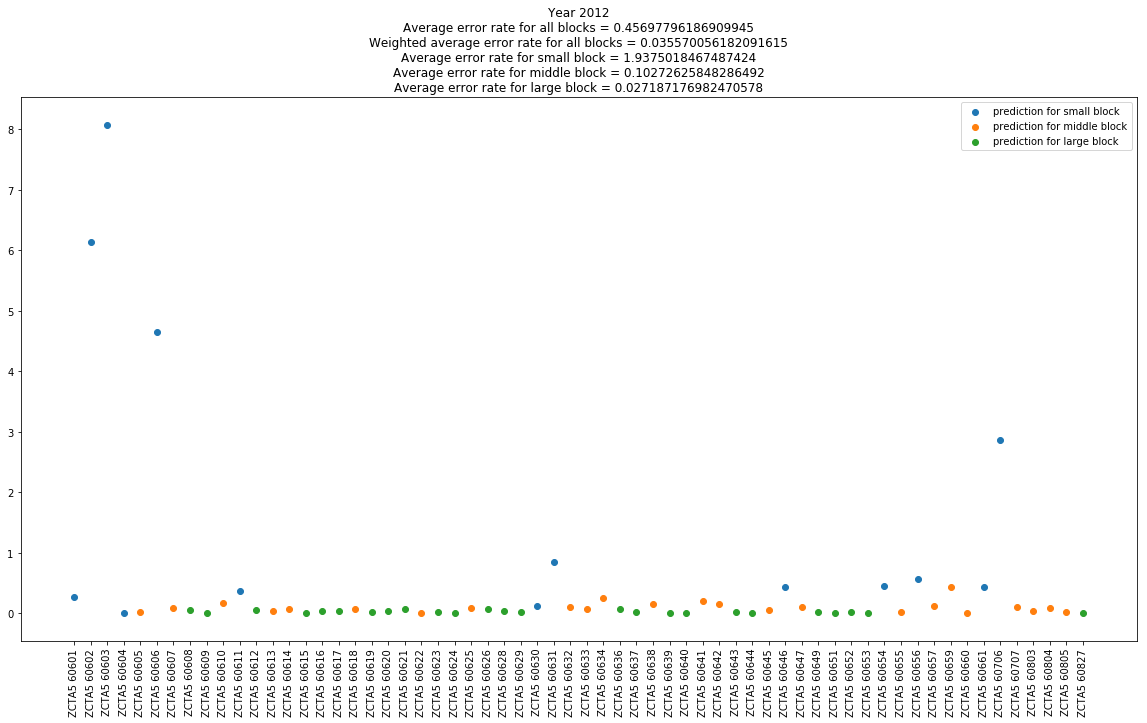

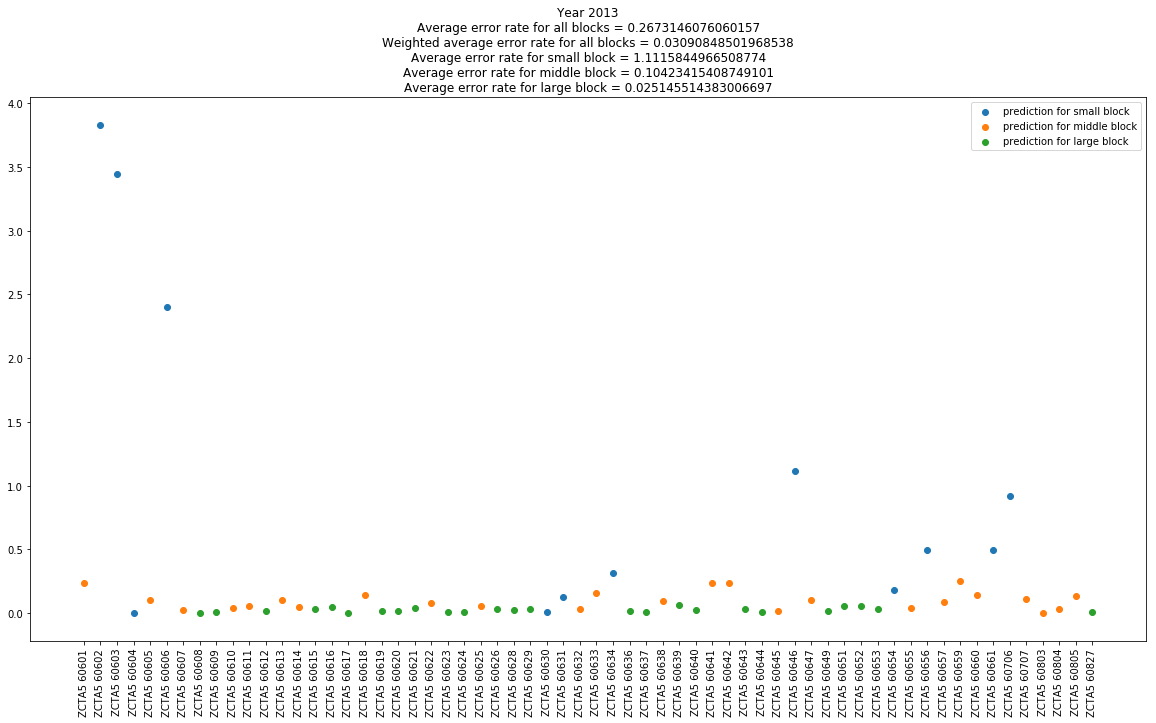

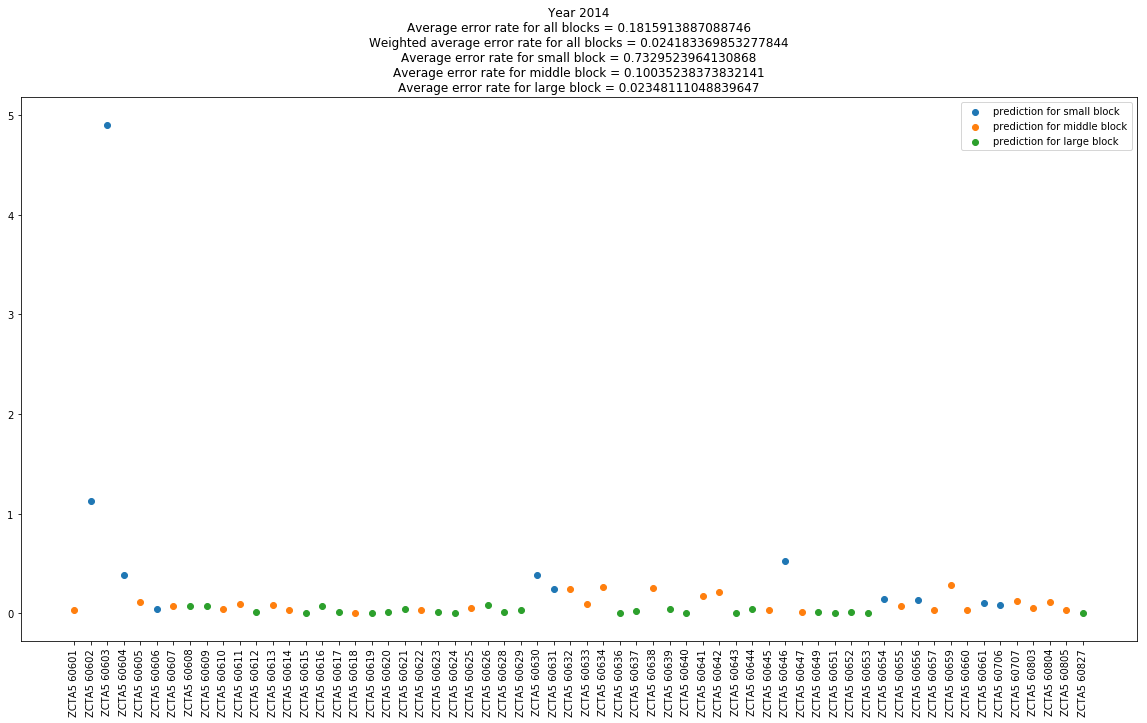

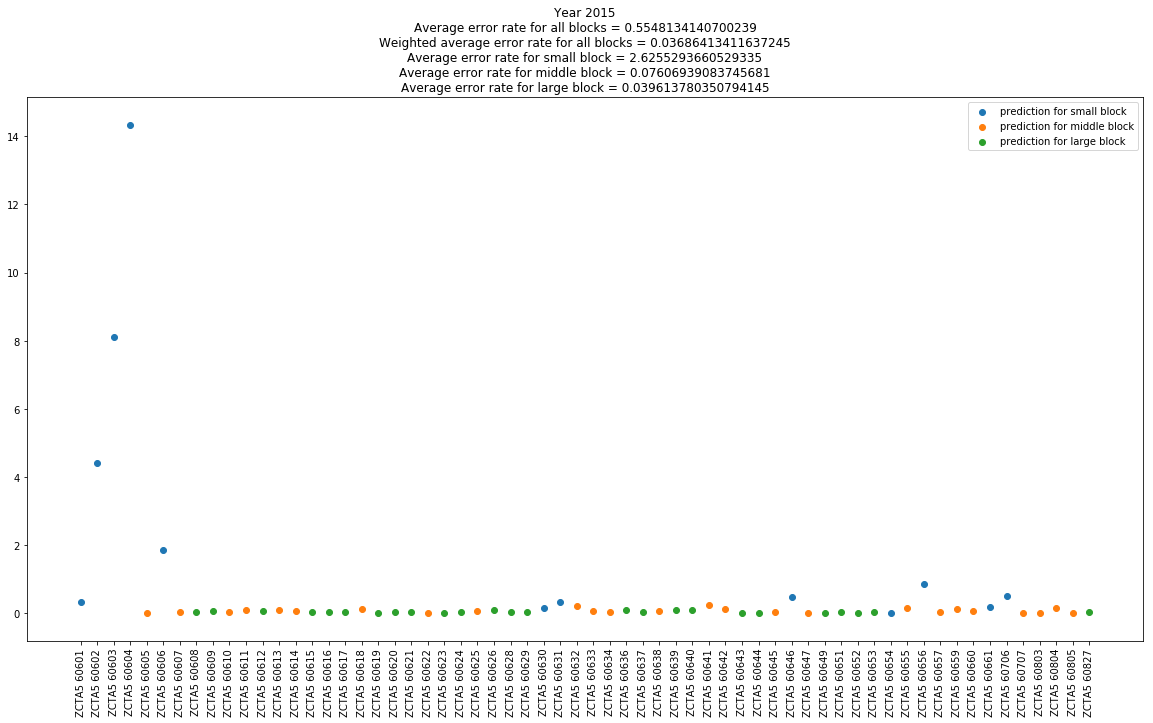

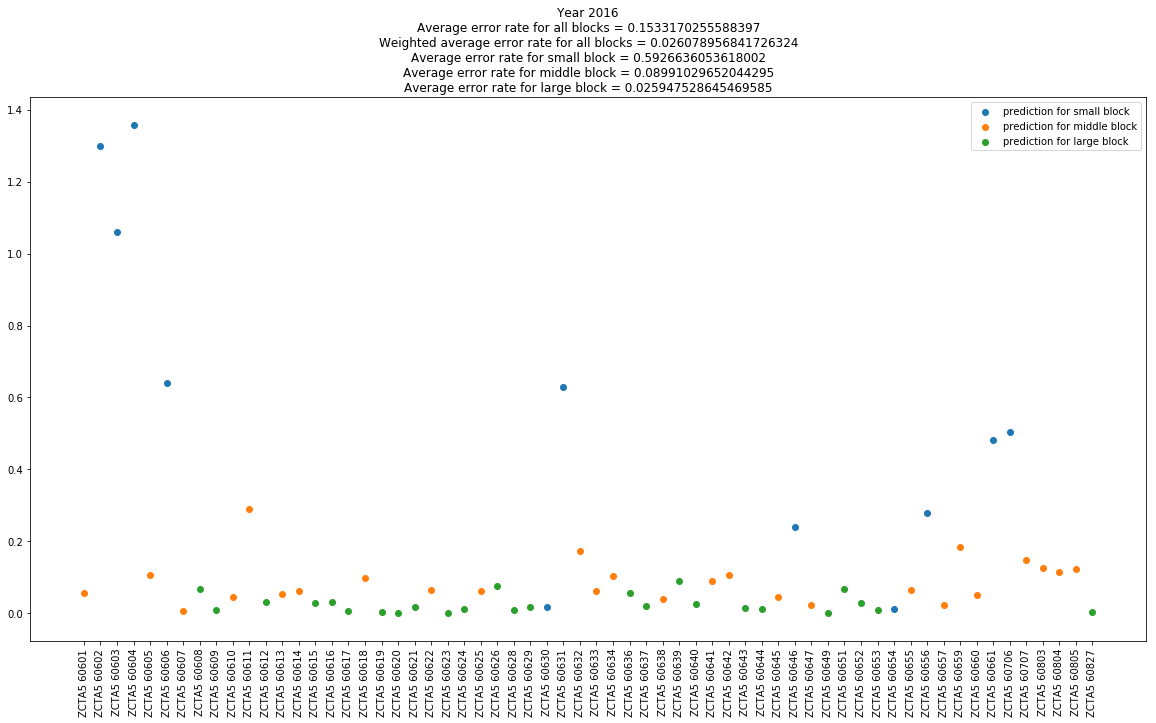

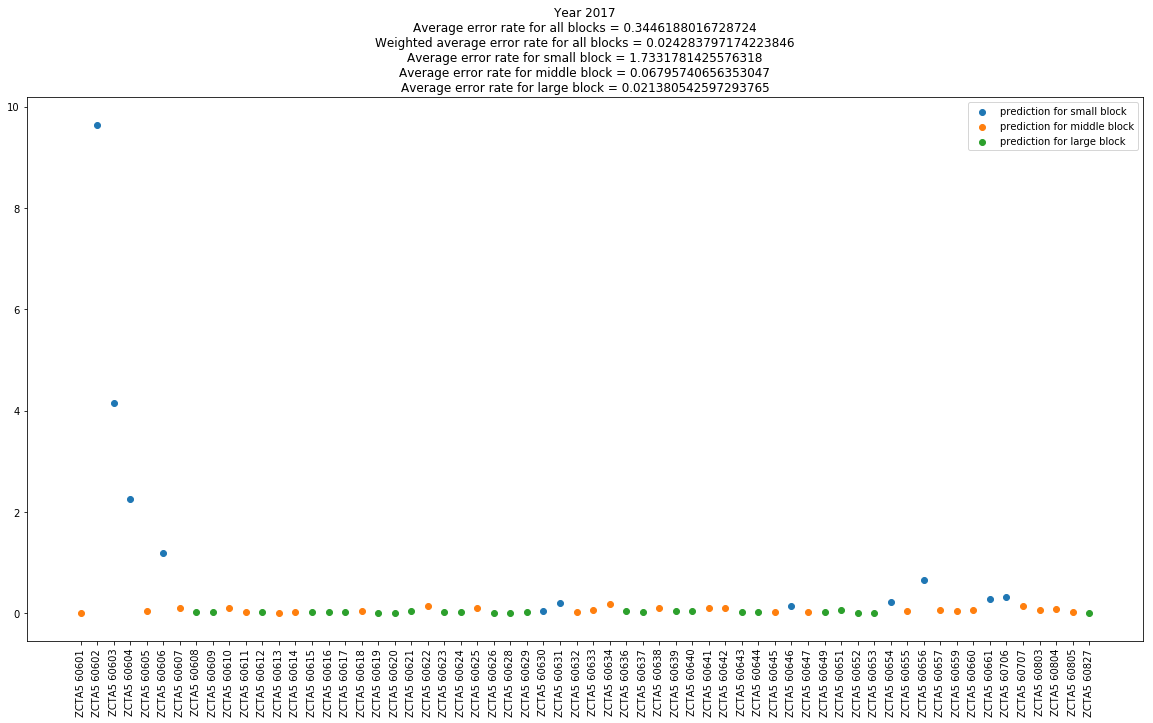

In [45]:
for k in range(6):
    predict = np.array(Predict[:,k+1], dtype = 'int')
    true = np.array(black_pop[:,k+1], dtype = 'int')
    Y1 = np.abs(predict/true-1)
    Y1[true==0] = 0
    Y1[62] = 0
    err_avg = Y1[:62].mean()
    err_avg1 = Y1[(true<1000)&(true>=0)].mean()
    err_avg_2 = Y1[(true<10000)&(true>=1000)].mean()
    err_avg_3 = Y1[true>10000].mean()
    err_avg_4 = (Y1[:62]*(true[:62]/(true[:62].sum()))).sum()
    fig, ax = plt.subplots(figsize = (20,10))
    ax.scatter(Geography[:62],Y1[:62], color = 'white', label = None)
    ax.scatter(Geography[(true<1000)&(true>=0)],Y1[(true<1000)&(true>=0)], label = 'prediction for small block')
    ax.scatter(Geography[(true<10000)&(true>=1000)],Y1[(true<10000)&(true>=1000)], label = 'prediction for middle block')
    ax.scatter(Geography[true>=10000],Y1[true>=10000], label = 'prediction for large block')
    ax.set_title('Year {}'.format(2012+k) + '\nAverage error rate for all blocks = '+str(err_avg)+'\nWeighted average error rate for all blocks = '+str(err_avg_4)+'\nAverage error rate for small block = '+str(err_avg1) + '\nAverage error rate for middle block = '+str(err_avg_2)+'\nAverage error rate for large block = '+str(err_avg_3))
    ax.legend()
    plt.xticks(rotation=90)
    plt.show